# Objectives

1. Estimate Clock Model
1. Filter Outliers
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Paths

In [2]:
# snakemake output
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# jupyter notebook output
tree_df_path = "../../results/parse_tree/parse_tree.tsv"
tree_df_dill = "../../results/parse_tree/parse_tree.df.obj"
tree_path = "../../results/parse_tree/parse_tree.nwk"
auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

# static dir
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"


outdir = "../../results/clock_model"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

# Clock model params

N_IQD = 3
MAX_ITER = 3
TC = "skyline"

## Import Tree

In [4]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [61]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

In [10]:
# Initialize stdout capture
# print("Estimating clock model...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# branch_length_mode:input --> tMRCA ~20,000 YBP

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )

tt.run(
    # Confident Parameteres
    max_iter=1,    
    n_iqd=N_IQD,   
    verbose=4,    
    infer_gtr=True,  
    use_covariation=False,     
    relaxed_clock={"slack" : 0.5, "coupling": 0},
    root=tt.tree.root, # "oldest" or tt.tree.root        
    resolve_polytomies=True,     
    vary_rate=True,      
    branch_length_mode = "joint", # joint, marginal  
    # Uncertain Parameters
    #Tc=TC,    
    #time_marginal="assign",
    )

tt.tree.ladderize(reverse=False)

# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_estimate.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.21	-SequenceData: loaded alignment.
1.21	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.21	-SeqData: making compressed alignment...

3.93	-SequenceData: constructed compressed alignment...
4.23	--ClockTree: Setting precision to level 2

4.31	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.

4.31	-TreeAnc.optimize_tree: sequences...

4.31	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

4.31	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
4.31	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
4.31	---TreeAnc._ml_anc_jo

125.83	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.00	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  


208.41	-TreeTime.resolve_polytomies: resolving multiple mergers...
208.46	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
208.46	---TreeTime._poly.merge_nodes: Delta-LH = 0.053
208.49	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
208.49	---TreeTime._poly.merge_nodes: Delta-LH = 0.097
208.52	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
208.52	---TreeTime._poly.merge_nodes: Delta-LH = 0.025
208.58	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.58	---TreeTime._poly.merge_nodes: Delta-LH = 0.033
208.63	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.63	---TreeTime._poly.merge_nodes: Delta-LH = 0.135
208.67	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.67	---TreeTime._poly.merge_nodes: Delta-LH = 0.051
208.71	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.71	---TreeTime._poly.merge_nodes: Delta-LH = 0.032
208.75	---TreeT

211.06	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.06	---TreeTime._poly.merge_nodes: Delta-LH = 0.069
211.10	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.10	---TreeTime._poly.merge_nodes: Delta-LH = 0.069
211.14	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.14	---TreeTime._poly.merge_nodes: Delta-LH = 0.069
211.17	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.17	---TreeTime._poly.merge_nodes: Delta-LH = 0.069
211.21	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.21	---TreeTime._poly.merge_nodes: Delta-LH = 0.045
211.24	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.24	---TreeTime._poly.merge_nodes: Delta-LH = 0.045
211.27	---TreeTime._poly.merge_nodes: creating new node as child of NODE327
211.27	---TreeTime._poly.merge_nodes: Delta-LH = 0.028
211.31	---TreeTime._poly.merge_nodes: creating new node as child of NODE372
211.31	

310.74	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
310.94	---TreeAnc._ml_anc_joint: ...done

310.96	-###ClockTree.calc_rate_susceptibility: run with upper bound of rate
      	 estimate

310.96	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
310.96	--ClockTree.init_date_constraints...
310.96	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
341.32	--ClockTree.date2dist: Setting new molecular clock. rate=9.389e-09,
      	  R^2=0.3121
341.33	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
341.33	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
341.33	----ClockTree.init_date_constraints -- WARNING: Branch is

476.69	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
476.85	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.85	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.85	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.85	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.85	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.86	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.86	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
476.86	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

## Quick Checks

In [11]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=2.148814885614286e-07, clock_length=2.148814885614286e-07, date='-4090-04-02', dist2root=0.0, mutation_length=2.148814885614286e-07, name='NODE0', original_length=0.0)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



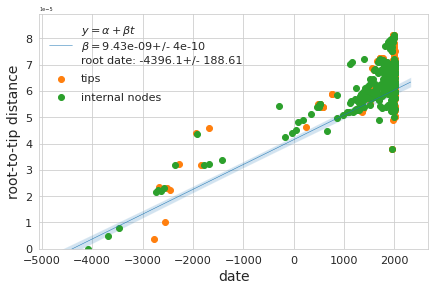

In [72]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

1074.18	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


Text(0.5, 1.0, 'Time Tree')

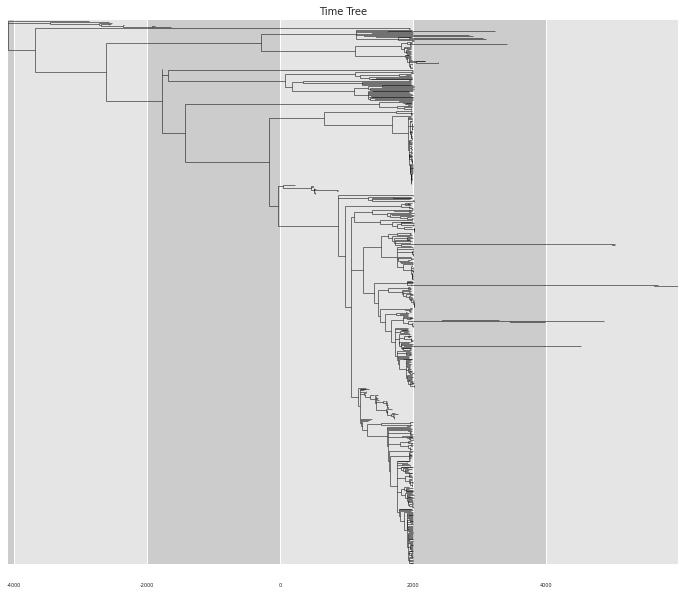

In [29]:
# Timetree
tt_copy = copy.deepcopy(tt)
fig, ax1 = treetime.treetime.plot_vs_years(tt_copy,
                         #confidence=(0.05,0.95), 
                         label_func = lambda x:"",
                         do_show=False)
ax1.set_title("Time Tree")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

PRUNING: GCA_001601675.1_ASM160167v1_genomic
PRUNING: GCA_001972405.1_ASM197240v1_genomic
PRUNING: GCA_001972385.1_ASM197238v1_genomic
PRUNING: GCA_001972395.1_ASM197239v1_genomic
PRUNING: GCA_002165475.1_ASM216547v1_genomic
PRUNING: GCA_001972415.1_ASM197241v1_genomic
PRUNING: GCA_001294815.1_ASM129481v1_genomic
PRUNING: GCA_000382505.1_Yersinia_pestis_G1670E_assembly_genomic
PRUNING: GCA_000382545.1_Yersinia_pestis_assembly_genomic
PRUNING: GCA_001188335.1_DYA_1_genomic
PRUNING: GCA_000834275.1_ASM83427v1_genomic
PRUNING: GCA_000834885.1_ASM83488v1_genomic
PRUNING: GCA_008630375.1_ASM863037v1_genomic
PRUNING: GCA_008630375.2_ASM863037v2_genomic
PRUNING: GCA_002412305.1_Y.pestis_A-1809_genomic
PRUNING: GCA_003086075.1_ASM308607v1_genomic
PRUNING: GCA_003086115.1_ASM308611v1_genomic
PRUNING: GCA_001613865.1_ASM161386v1_genomic


Text(0, 0.5, '')

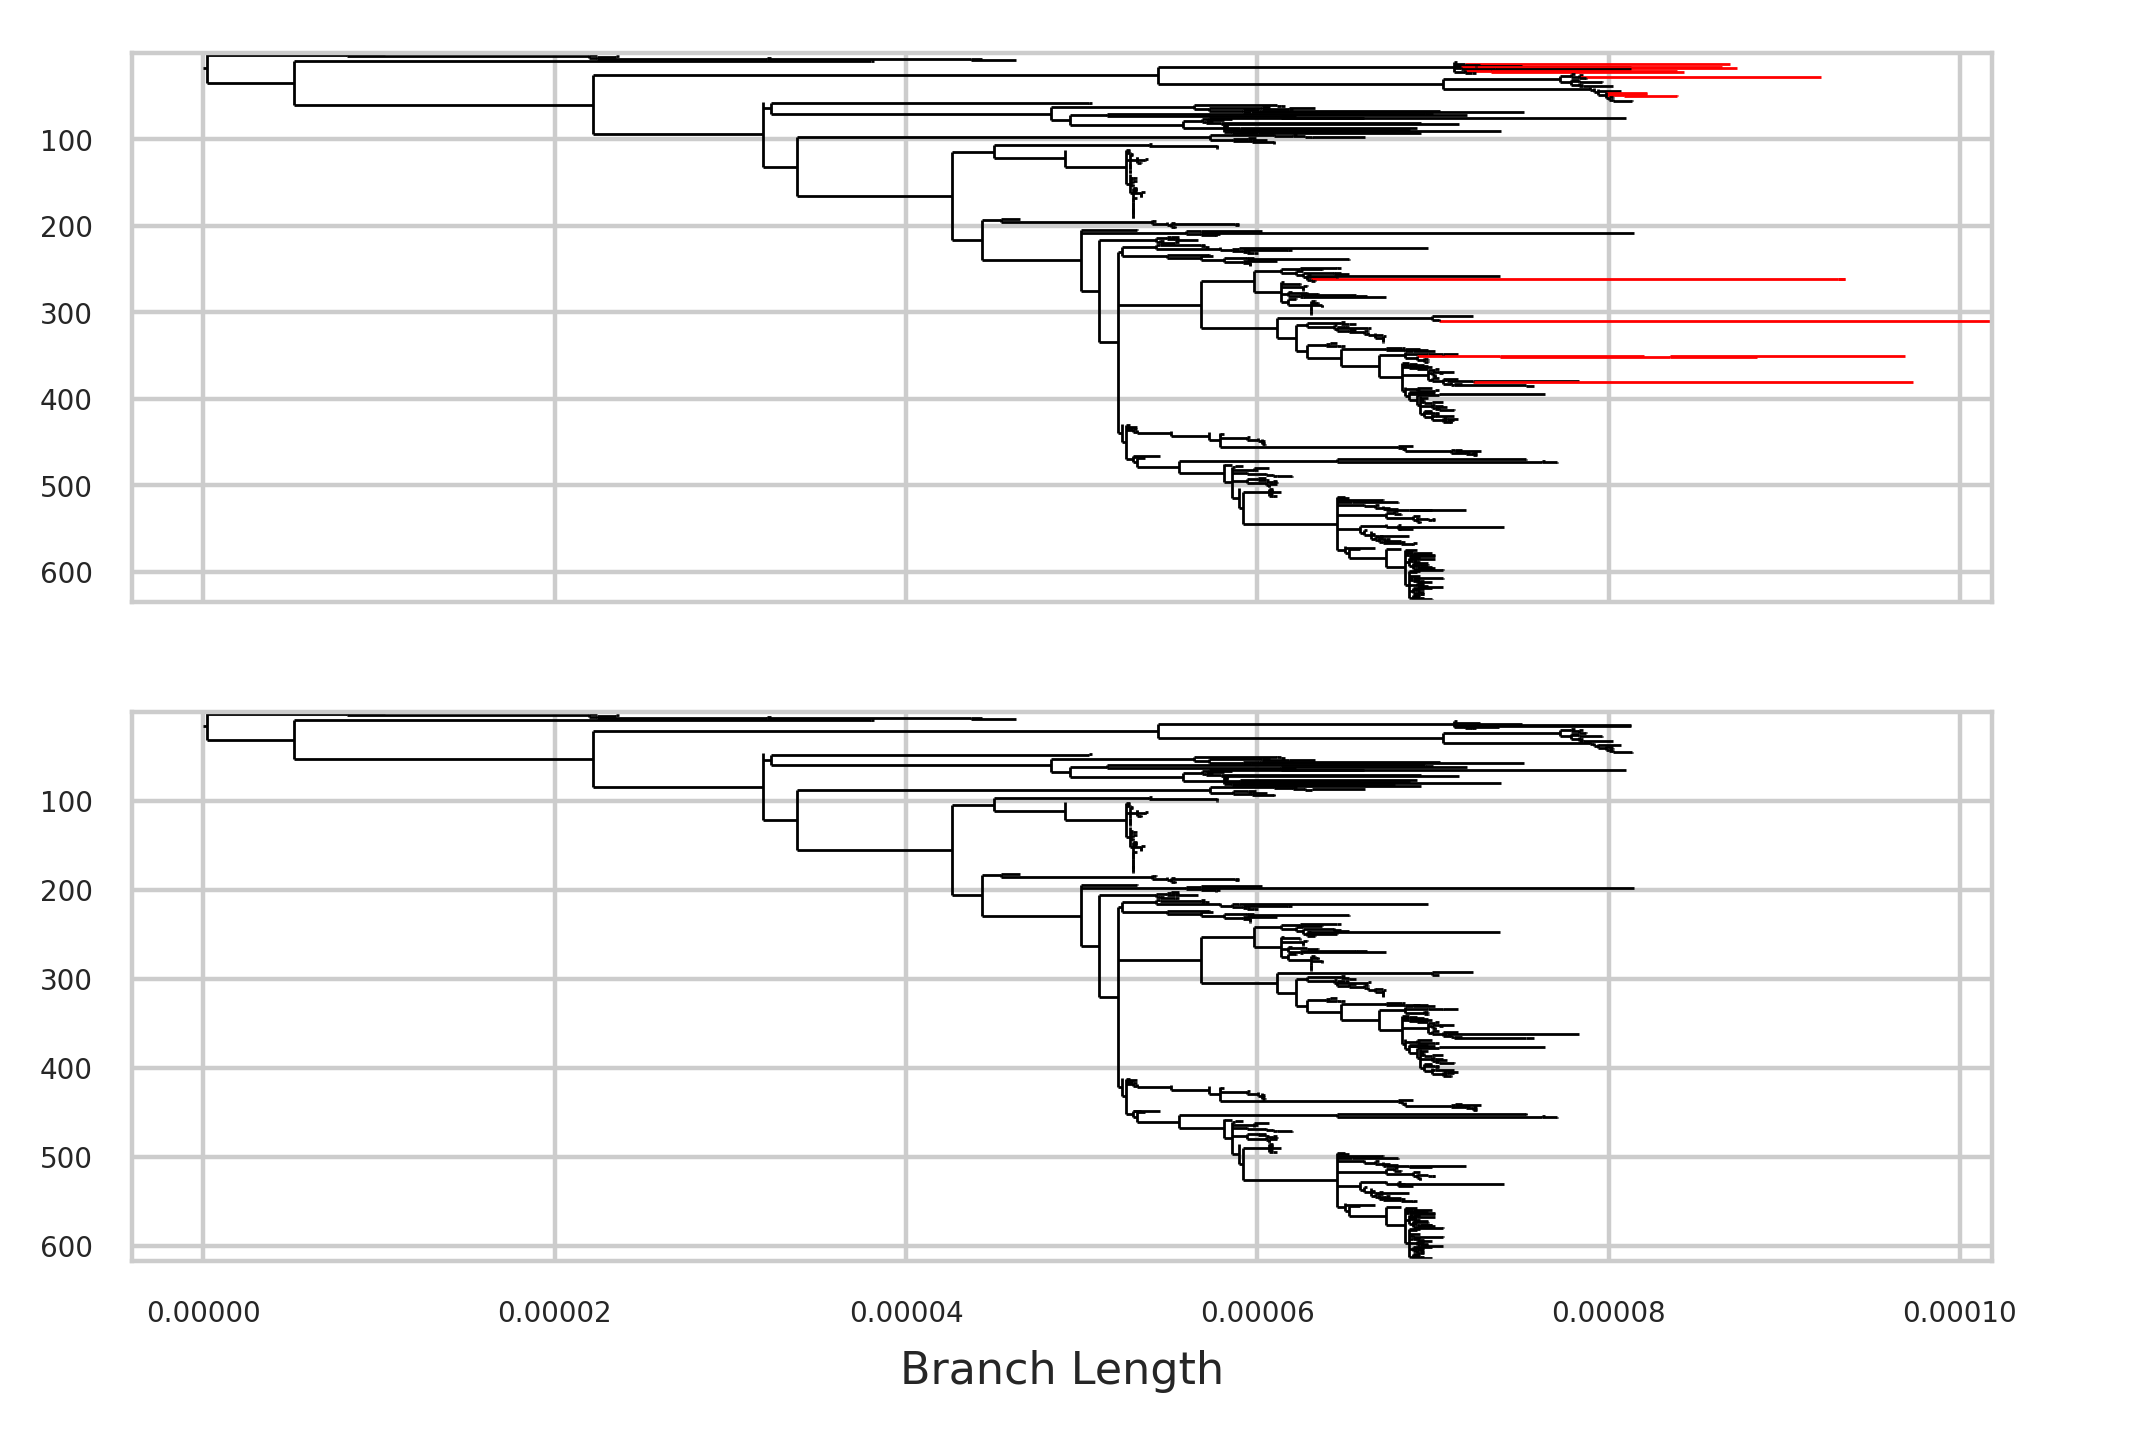

In [49]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

Phylo.draw(tt_pre.tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax1,
        )  
Phylo.draw(tt_prune.tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax2,
        )

ax1.set_xlabel("")
ax1.set_ylabel("")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Update tt variable

In [57]:
tt = tt_prune

## Timetree After Pruning

1935.56	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


Text(0.5, 1.0, 'Time Tree')

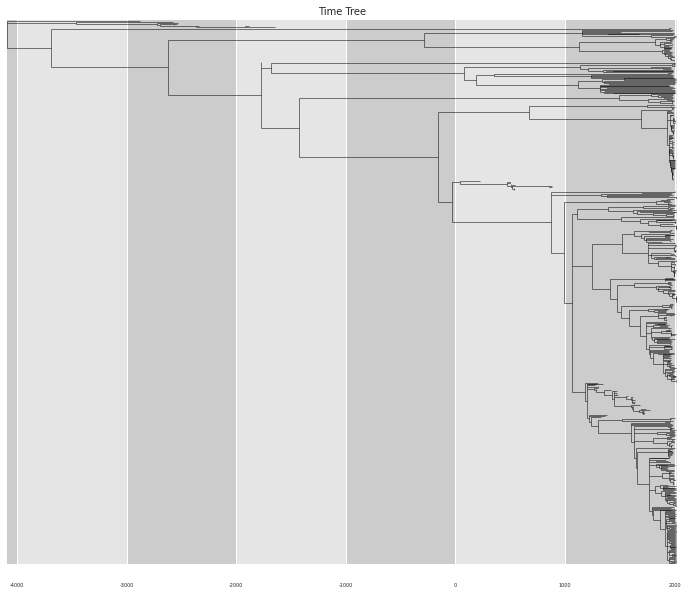

In [58]:
# Timetree
fig, ax1 = treetime.treetime.plot_vs_years(tt,
                         #confidence=(0.05,0.95), 
                         label_func = lambda x:"",
                         do_show=False)
ax1.set_title("Time Tree")

## Remove Collapsed Nodes from Dataframe

In [62]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000077,631.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [63]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [64]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
HAS_MARGINAL = False
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Set the boolean flag on the first time encountered
        if not HAS_MARGINAL:
            HAS_MARGINAL = True
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

2016.08	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


## RTT

In [65]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

2019.17	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.429372e-09,1.000000,2.148815e-07,-4090-04-02,-4089.750250,0.100000,0.100000,16.185769,-4089.750250,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.795600e-09,0.296478,3.655186e-06,-2876-01-01,-2875.999894,1213.750356,1213.850356,1.000000,-2776.500000,0.000004,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.314331e-08,1.393869,7.960980e-06,-3465-04-24,-3464.689611,625.060640,625.160640,3.156250,-3464.689611,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.456374e-09,0.260502,2.150224e-06,-2582-04-23,-2581.691944,882.997666,1508.158306,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.942639e-08,2.060200,1.378555e-05,-2728-10-08,-2727.232397,737.457214,1362.617853,4.312500,-2727.232397,0.000022,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000330,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.429372e-09,1.000000,3.212449e-20,1462-02-15,1462.124652,12.172025,5551.974902,424.500000,1462.124652,0.000058,False
NODE_0000365,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.429372e-09,1.000000,3.202082e-20,1962-08-07,1962.598406,11.327116,6052.448656,482.750000,1962.598406,0.000060,False
NODE_0000366,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.429372e-09,1.000000,3.202082e-20,1964-01-01,1964.000106,1.401700,6053.850356,483.500000,1964.000106,0.000060,False


## Skyline

In [66]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

---
# Export

## Tree and Dataframe

In [68]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)
    
# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
out_path_pickle_tree = os.path.join(outdir,  SCRIPT_NAME + ".treetime.obj" )


Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
with open(out_path_pickle_tree,"wb") as outfile:
    dill.dump(tt, outfile)

## Augur JSON

In [69]:
augur_dict = augur_export(
    tree_path=tree_path, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 2.2998947198611292e-08, 'rate_fold_change': 2.439075105792843, 'mutation_length': 1.7200806304621248e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'clock_length': 54.64628251490467}


## Auspice JSON

In [70]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/clock_model/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/clock_model/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
